In [1]:
import cdms2 as cdms
import MV2 as MV
import cdtime,cdutil,genutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# Local solution
# If running remotely, uncomment the following code:
# %%bash
# git clone https://github.com/katemarvel/CMIP5_tools
# import CMIP5_tools as cmip5
import sys,os
sys.path.append("/Users/kmarvel/Google Drive/python-utils")

import CMIP5_tools as cmip5
import DA_tools
import Plotting

from eofs.cdms import Eof
from eofs.multivariate.cdms import MultivariateEof
%matplotlib inline

# Data
Regional monthly mean precipitation data has been calculated for the central/eastern Sahel (east of 0$^{\circ}$ longitude) and the western Sahel (west) in all CMIP5 models and three observational datasets.

In [2]:
cmip_directory = "/Users/kmarvel/Google Drive/Sahel/DATA/CMIP5/INTENSITY/"
obs_directory = "/Users/kmarvel/Google Drive/Sahel/DATA/OBS/PROCESSED/"

Some helper functions: bootstrap_slopes calculates all (overlapping) L-year trends in a given time series.  Function by_month reshapes a monthly time series of shape (nt,) into one of shape(nt/12,12).

In [3]:
def bootstrap_slopes(noise,L,x=None):
    nt=noise.shape[0]-L
    test = MV.zeros((nt,L))
    
    for i in range(nt):
        test[i]=noise[i:L+i]
    test.setAxis(1,noise[:L].getAxis(0))
    if x is None:
        return cmip5.get_linear_trends(test)  
    else:
        to_return=MV.zeros(nt)
        for i in range(nt):
            to_return[i]=float(genutil.statistics.linearregression(test[i],x=x)[0])
        return to_return
            


def by_month(X):
    """
    X is a cdat variable with a labeled time axis with time step = 1 month.
    This function returns variable with one extra axis with shape (12)
    """
    time_i=X.getAxisIds().index('time')
    nm=X.shape[time_i]
    nyears = int(nm/12)
    newtime=(nyears,12)
    d={}
    for i in range(len(X.shape)):
        d[i]=X.shape[i]
    d[time_i]=newtime
    #now make the new shape
    newshape=()
    for i in range(len(X.shape)):
        x=d[i]
        if type(x)==type(()):
            newshape+=x
        else:
            newshape+=(x,)
    Xr=MV.array(X.asma().reshape(newshape))
    axlist = range(len(X.shape))
    for i in axlist:
        if i != time_i:
            Xr.setAxis(i,X.getAxis(i)) 
    monthax = cdms.createAxis(np.arange(12)+1)
    monthax.id="months"
    monthax.months=str(["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"])
    Xr.setAxis(time_i+1,monthax)
    
    #yearax = cdms.createAxis(X.getTime()[0::12]) #####FIX 
    #for att in X.getTime().attributes:
    #    setattr(yearax,att,X.getTime().attributes[att])
    
   # yearax.id="time"
   # yearax.designateTime()
    yearax=cdutil.YEAR(X).getTime()
    Xr.setAxis(time_i,yearax)
    
    return Xr

            
def plot_multivariate(solver,i=0,fac=None):
    """Plot a multivariate EOF"""
    pr_CE_eofs,intensity_CE_eofs,pr_W_eofs,intensity_W_eofs=solver.eofs()
    if fac is None:
        fac=DA_tools.get_orientation(solver)
    plt.plot(pr_CE_eofs[i].asma()*fac,c=cm.PuOr(.9),label="East: precipitation")
    plt.plot(intensity_CE_eofs[i].asma()*fac,c=cm.PuOr(.8),ls=":",label="East: number of rainy days")

    plt.plot(pr_W_eofs[i].asma()*fac,c=cm.PuOr(.2),label="West: precipitation")
    plt.plot(intensity_W_eofs[i].asma()*fac,c=cm.PuOr(.1),ls=":",label="West: number of rainy days")
    months=["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
    plt.xticks(np.arange(12),months)
    plt.legend()
    plt.axhline(0,c="k",ls=":")
    plt.ylabel("EOF loading")
    

Data and methods for CMIP5 model data.

In [4]:
class CMIP5DATA():
    """
    Get east, west, and total Sahel precipitation data.  
    Experiment can be one of
    *1pctCO2
    *AA
    *historical
    *historicalGHG
    *historical-rcp85 (spliced)
    *piControl
    *rcp85
    """
    def __init__(self,experiment,base_period=None):
        if base_period is None:
            base_period=('1900-1-1','1950-12-31')
        f=cdms.open(cmip_directory+"cmip5.sahel_precip_intensity."+experiment+".nc")
        
        #total=f("pr_sahel")
        #f.close()
        self.raw={}
        self.bymonth={}
        self.anomalies={}
        self.climatology={}
        self.mma={}
        for variable in ["pr_CE","intensity_CE","pr_W","intensity_W"]:
            #raw data
            data=f(variable)
            self.raw[variable]=data
            #partitioned by month
            bymonth=by_month(data)
            self.bymonth[variable]=bymonth
            #climatology
            clim=MV.average(bymonth(time=base_period),axis=1)
            self.climatology[variable]=clim
            #anomalies
            anomalies=cmip5.cdms_clone(bymonth.asma()-clim.asma()[:,np.newaxis,:],bymonth)
            self.anomalies[variable]=anomalies
            #multi-model average (first average over ensemble members, then models)
            mma=MV.average(cmip5.ensemble2multimodel(anomalies),axis=0)
            self.mma[variable]=mma
    def fingerprint(self,include=["pr_CE","intensity_CE","pr_W","intensity_W"],time_bounds=None):
        if time_bounds is None:
            time_bounds = (cmip5.start_time(self.mma["pr_CE"]),cmip5.stop_time(self.mma["pr_CE"]))
        if (type(include)==type("string")):
            solver=Eof(self.mma(include)(time=time_bounds))
        else:
            data=[]
            for incl in include:
                data+=[self.mma[incl](time=time_bounds)/np.std(self.mma[incl](time=time_bounds))]
                solver=MultivariateEof(data)
        solver.variables=include
        return solver
    
    def project_on_solver(self,projections_from=None,\
                          time_bounds=None,\
                          include=["pr_CE","intensity_CE","pr_W","intensity_W"],\
                          eof_number=0):
        if projections_from is None:
            projections_from=self
        solver=self.fingerprint(include=include,time_bounds=time_bounds)
        fac=DA_tools.get_orientation(solver)
        nmod,nyears,nmonths=getattr(projections_from,"anomalies")["pr_CE"].shape
        P=MV.zeros((nmod,nyears))
        
        for modeli in range(nmod):
            
            if (type(include)==type("string")):
                to_proj=getattr(projections_from,"anomalies")[include][modeli]
            else:
                to_proj=[]
                for incl in include:
                    dat=getattr(projections_from,"anomalies")[incl][modeli]
                    to_proj+=[dat/np.std(dat)]
            P[modeli]=solver.projectField(to_proj)[:,eof_number]*fac
        P.setAxis(0,getattr(projections_from,"anomalies")["pr_CE"].getAxis(0))
        P.setAxis(1,getattr(projections_from,"anomalies")["pr_CE"].getAxis(1))
        return P
        
            
        


In [5]:
#LOAD THE DATA
h85=CMIP5DATA("historical-rcp85")

aa=CMIP5DATA("AA")

/Users/kmarvel/anaconda2/envs/cdat2/lib/python2.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/kmarvel/anaconda2/envs/cdat2/lib/python2.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


## Model selection
Because more models performed historical + rcp8.5 simulations than aerosol-only ones, we also need a class for h85 data from only these select models

In [6]:
aa_models=cmip5.models(aa.raw["pr_CE"])

h85_models=cmip5.models(h85.raw["pr_CE"])
aamod=[y.split(".")[1] for y in aa_models]
h85mod=[y.split(".")[1] for y in h85_models]
okmods=np.intersect1d(np.unique(aamod),np.unique(h85mod))
h85_keep=[]
for model in h85mod:
    if model in okmods:
        h85_keep+=[h85mod.index(model)]
newanoms={}
newmma={}
for key in h85.anomalies.keys():
    data=h85.anomalies[key]
    modax,tax,monthax=data.getAxisList()
    newdata=MV.array(data.asma()[np.array(h85_keep)])
    newmodax=cmip5.make_model_axis(np.array(h85_models)[np.array(h85_keep)].tolist())
    newdata.setAxisList([newmodax,tax,monthax])
    newdata.id=data.id
    newanoms[key]=newdata
    #print(cmip5.ensemble2multimodel(newdata).shape)
    newmma[key]=MV.average(cmip5.ensemble2multimodel(newdata),axis=0)
class SelectCMIP5DATA(CMIP5DATA):
    def __init__(self,experiment,newanoms,newmma):
        self.mma=newmma
        self.anomalies=newanoms

In [7]:


select_h85=SelectCMIP5DATA("historical-rcp85",newanoms,newmma) 

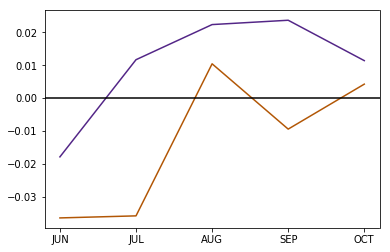

In [31]:
#Trends in R1
r1east=h85.mma["intensity_CE"]
toteast=h85.mma["pr_CE"]

#plt.plot(cmip5.get_linear_trends(r1east*30).asma())
r1west=h85.mma["intensity_W"]
totwest=h85.mma["pr_W"]
tmpx=np.arange(12)[5:10]
plt.plot(tmpx,cmip5.get_linear_trends(totwest/(30*r1west)).asma()[5:10],c=cm.PuOr(.1))
plt.plot(tmpx,cmip5.get_linear_trends(toteast/(30*r1east)).asma()[5:10],c=cm.PuOr(.9))
months=["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"][5:10]
plt.xticks(tmpx,months)
plt.axhline(0,c="k")

In [9]:
test=h85.raw["intensity_CE"]
actest=cdutil.ANNUALCYCLE.climatology(test)
print(actest.shape)

(31, 12)


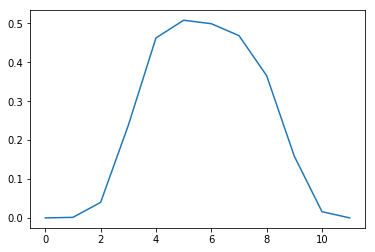

In [10]:
plt.plot(actest[10].asma())

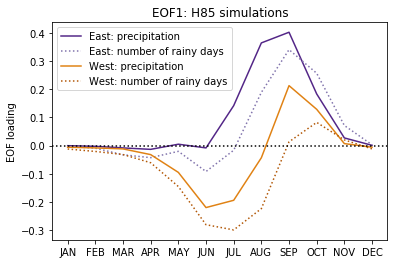

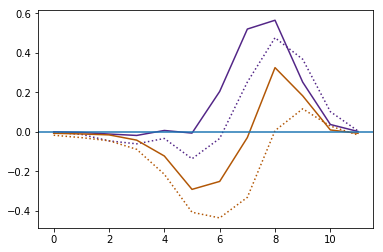

In [11]:
#EOF 1
plot_multivariate(h85.fingerprint())
plt.title("EOF1: H85 simulations")
#plt.savefig("FIGS/EOF1_H85.png")
intensity_only=h85.fingerprint(include=["intensity_CE","intensity_W"])
plt.figure()
eofce,eofw=intensity_only.eofs()
plt.plot(eofce.asma()[0],c=cm.PuOr(.9),ls=":")
plt.plot(eofw.asma()[0],c=cm.PuOr(.1),ls=":")
pr_only=h85.fingerprint(include=["pr_CE","pr_W"])

eofcep,eofwp=pr_only.eofs()
plt.plot(-1*eofcep.asma()[0],c=cm.PuOr(.9),ls="-")
plt.plot(-1*eofwp.asma()[0],c=cm.PuOr(.1),ls="-")
plt.axhline(0)

The fingerprint of aerosols (leading EOF) looks like the inverse of EOF2 for the historical-rcp85 simulation

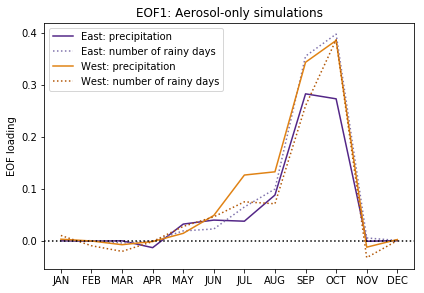

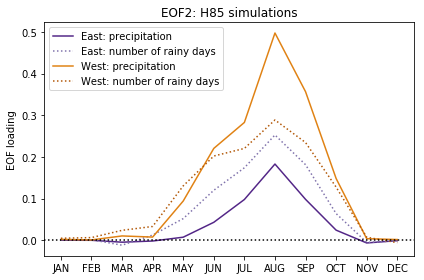

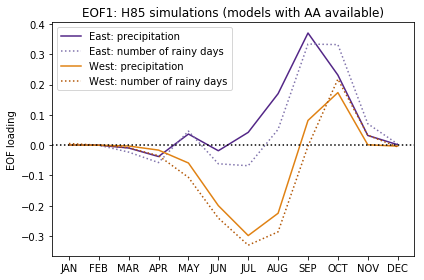

In [12]:
plt.figure()
plot_multivariate(aa.fingerprint(),fac=-1)
plt.tight_layout()
plt.title("EOF1: Aerosol-only simulations")
#plt.savefig("FIGS/EOF1_AA.png")
plt.figure()
plot_multivariate(h85.fingerprint(),i=1)
plt.title("EOF2: H85 simulations")
plt.tight_layout()
#plt.savefig("FIGS/EOF2_H85.png")
plt.figure()
plot_multivariate(select_h85.fingerprint(),i=0)
plt.title("EOF1: H85 simulations (models with AA available)")
plt.tight_layout()
#plt.savefig("FIGS/EOF1_H85_select.png")

Text(0,0.5,'Temporal Amplitude')

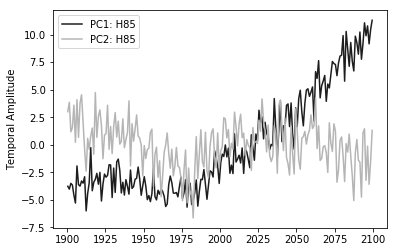

In [13]:
Plotting.time_plot(h85.fingerprint().pcs()[:,0],label="PC1: H85",c=cm.Greys(.9))
Plotting.time_plot(h85.fingerprint().pcs()[:,1],label="PC2: H85",c=cm.Greys(.4))
plt.legend()
plt.ylabel("Temporal Amplitude")
#Plotting.time_plot(-1*aa.fingerprint().pcs()[:,1],label="PC1: AA")

The projections onto the aerosol-only fingerprint decrease until ca 1975 and then increase with time- probably because the AA fingerprint is not orthogonal to the greenhouse gas fingerprint, and GHG-induced precipitation increases are projecting onto the AA fingerprint.  EOF2 is orthogonal to H85 by construction.  Do we need to check this by looking at the fingerprints for 1pctCO2 and ascertaining that EOF2 isn't present there?

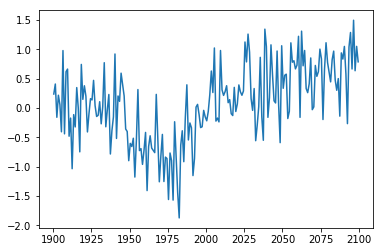

In [14]:
Paa=aa.project_on_solver(projections_from=h85)
#Plotting.time_plot(-1*MV.average(cmip5.ensemble2multimodel(Paa),axis=0))
Plotting.time_plot(-1*MV.average(Paa,axis=0))

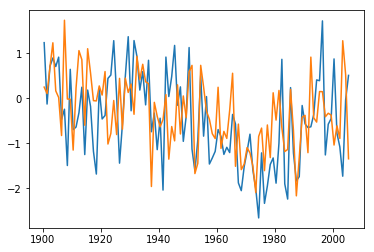

In [15]:
P_aa_on_eof2=h85.project_on_solver(projections_from=aa,eof_number=1)
Plotting.time_plot(MV.average(P_aa_on_eof2,axis=0))
P_aa_on_eof1=h85.project_on_solver(projections_from=aa,eof_number=0)
Plotting.time_plot(MV.average(P_aa_on_eof1,axis=0))

Check the stability of the h85 fingerprint by calculating it over the 20th and 21st century.  This indicates that in models, the dominant forced response over the 20th century is very different from the dominant forced response over the 21st century.   

0.271294680592
0.498072337723


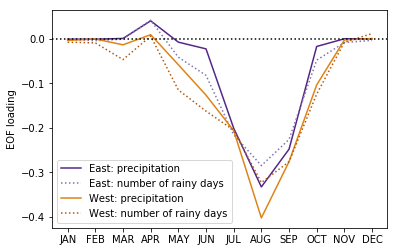

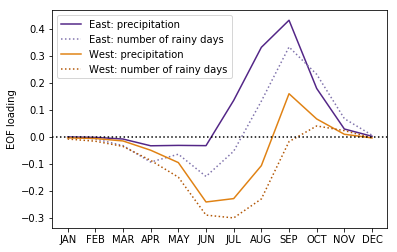

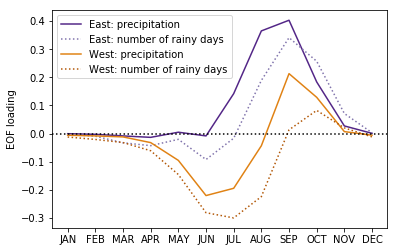

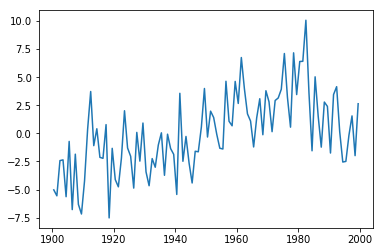

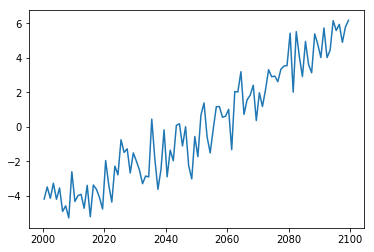

In [16]:
cen20=h85.fingerprint(time_bounds=('1900-1-1','1999-12-31'))
cen21=h85.fingerprint(time_bounds=('2000-1-1','2099-12-31'))
plt.figure()
plot_multivariate(cen20)
plt.figure()
plot_multivariate(cen21)
plt.figure()
plot_multivariate(h85.fingerprint(),i=0)
plt.figure()

Plotting.time_plot(cen20.pcs()[:,0])
plt.figure()
Plotting.time_plot(-1*cen21.pcs()[:,0])
print(cen20.varianceFraction()[0])
print(cen21.varianceFraction()[0])

Is this just an artifact of the aerosol-only runs being different models?  To check this, look at h85 fingerprint using only those models that also did aerosol-only runs with daily data:

In [17]:
include=["pr_CE","pr_W"]#,"intensity_CE","intensity_W"]
include=["intensity_CE","intensity_W"]
eofsaa=aa.fingerprint(include=include).eofs()
aatest=MV.array([eofsaa[i][0] for i in range(len(include))])
eof2h85=h85.fingerprint(include=include).eofs()
h85test=np.array([eof2h85[i][0] for i in range(len(include))])
h85test2=np.array([eof2h85[i][1] for i in range(len(include))])
print(h85.fingerprint(include=include).projectField(aatest)[0])
print(h85.fingerprint(include=include).projectField(aatest)[1])
#print(np.dot(h85test.flatten(),aatest.flatten()))
#plt.plot(eof2h85[0].asma()[0])
#plt.plot(-1*eofsaa[0].asma()[0])
#plt.plot(-1*eof2h85[1].asma()[0])

0.422785271663
0.690355515337


PC2 (associated with EOF2) of historical-rcp85 tracks PC1 (associated with leading EOF) of aerosol-only simulations very well over the historical period.

0.11384617716795192
0.6069313661075273


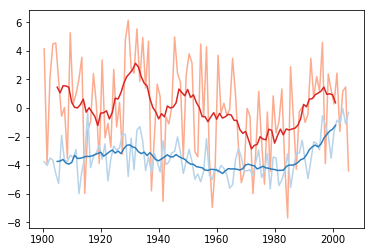

In [18]:
aa_hist=aa.fingerprint().pcs()[:,0]
sh85_hist=h85.fingerprint().pcs()[:,0][:len(aa_hist)]
Plotting.time_plot(-1*aa_hist,color=cm.Reds(.3))
Plotting.time_plot(sh85_hist,color=cm.Blues(.3))
print(np.corrcoef(-1*aa_hist.asma(),sh85_hist.asma())[0,1])
smoothaa=genutil.filters.runningaverage(aa_hist,10)
smoothh85=genutil.filters.runningaverage(sh85_hist,10)
Plotting.time_plot(-1*smoothaa,color=cm.Reds(.7))
Plotting.time_plot(smoothh85,color=cm.Blues(.7))
print(np.corrcoef(-1*smoothaa.asma(),smoothh85.asma())[0,1])

Contrast this with the leading EOF for h85

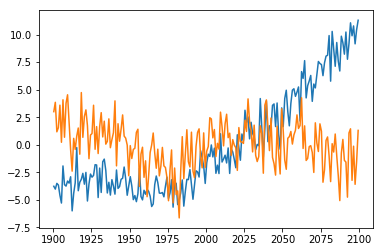

In [19]:
P=h85.project_on_solver(eof_number=0)
#Plotting.time_plot(MV.average(cmip5.ensemble2multimodel(P),axis=0))
Plotting.time_plot(h85.fingerprint().pcs()[:,0])
Plotting.time_plot(h85.fingerprint().pcs()[:,1])

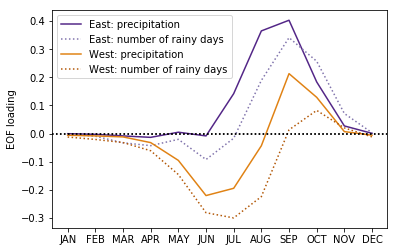

In [20]:
solver=h85.fingerprint()
aasolver=aa.fingerprint()
plot_multivariate(solver,i=0)
plt.axhline(0,c="k",ls=":")

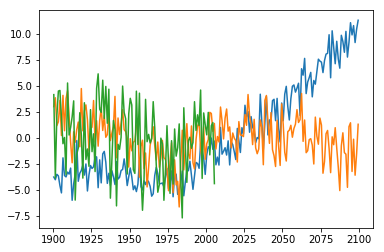

In [21]:
fac=DA_tools.get_orientation(solver)
Plotting.time_plot(solver.pcs()[:,0]*fac)
Plotting.time_plot(solver.pcs()[:,1]*fac)
Plotting.time_plot(aasolver.pcs()[:,0]*-1)

In [22]:
aapc=aasolver.pcs()[:,0]*-1

h85pc2=solver.pcs()[:,1](time=('1900-1-1','2005-12-31'))
cmip5.stop_time(h85pc2)

2005-7-1 0:0:0.0

In [23]:
class PICONTROLDATA():
    """
    Get east, west, and total Sahel precipitation data.  
    Experiment can be one of
    *1pctCO2
    *AA
    *historical
    *historicalGHG
    *historical-rcp85 (spliced)
    *piControl
    *rcp85
    """
    def __init__(self):
        
        f=cdms.open(cmip_directory+"cmip5.sahel_precip_intensity.piControl.nc")
        
        #total=f("pr_sahel")
        #f.close()
        self.raw={}
        self.bymonth={}
        self.anomalies={}
        self.climatology={}
        self.concatenated={}
        for variable in ["pr_CE","intensity_CE","pr_W","intensity_W"]:
            #raw data
            data=f(variable)
            self.raw[variable]=data
            #partitioned by month
            bymonth=by_month(data)
            self.bymonth[variable]=bymonth
            #climatology
            clim=MV.average(bymonth,axis=1)
            self.climatology[variable]=clim
            #anomalies
            anomalies=cmip5.cdms_clone(bymonth.asma()-clim.asma()[:,np.newaxis,:],bymonth)
            self.anomalies[variable]=anomalies
            #multi-model average (first average over ensemble members, then models)
            concatenated=DA_tools.concatenate_this(anomalies)
            self.concatenated[variable]=concatenated
    def fingerprint(self,include=["pr_CE","intensity_CE","pr_W","intensity_W"]):
        if (type(include)==type("string")):
            solver=Eof(self.concatenated(include))
        else:
            data=[]
            for incl in include:
                data+=[self.concatenated[incl]/np.std(self.concatenated[incl])]
                solver=MultivariateEof(data)
        solver.variables=include
        return solver
    
    def project_on_solver(self,solver,include=["pr_CE","intensity_CE","pr_W","intensity_W"],eof_number=0):
        #solver=self.fingerprint(include=include)
        fac=DA_tools.get_orientation(solver)
        nmod,nyears,nmonths=self.anomalies["pr_CE"].shape
        to_proj=[]
        
            
        for incl in include:
            dat=self.concatenated[incl]
            to_proj+=[dat/np.std(dat)]
        P=solver.projectField(to_proj)[:,eof_number]*fac
       
        return P
        
            

Project the pre-industrial control onto the solver to get a measure of noise

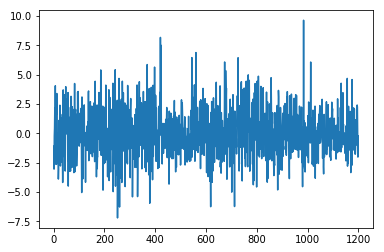

In [24]:
piC=PICONTROLDATA()
solver=h85.fingerprint()
picproj=piC.project_on_solver(solver)
Plotting.time_plot(picproj)

Leading noise mode: EOF1 of concatenated pre-industrial control simulations.  Compare this to the fingerprint and second EOF.

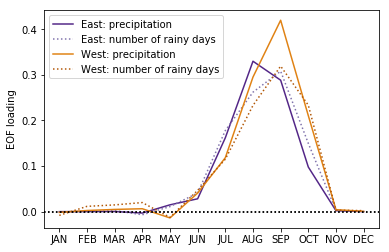

In [25]:
piC=PICONTROLDATA()
leading_noise_mode=piC.fingerprint()
plot_multivariate(leading_noise_mode,i=0)

plt.axhline(0,c="k",ls=":")

In [26]:
def TOE(projections,noise,starttime=None,L_init=30):
    nmod,nyears=projections.shape
    
    
    if starttime is None:
        starttime=cdtime.comptime(2000,1,1)
    endtime=starttime.add(L_init,cdtime.Years)
    y2100=cdtime.comptime(2100,1,1)
    yrs=2100-endtime.year+1
    SN=MV.zeros((nmod,yrs))
    
    counter=0
    while endtime.cmp(y2100)<=0:
        trunc=projections(time=(starttime,endtime))
        L=trunc.shape[1]
        signals=cmip5.get_linear_trends(trunc)
        
        slopes=bootstrap_slopes(noise,L)
        SN[:,counter]=signals/np.std(slopes)
        endtime=endtime.add(1,cdtime.Years)
        counter+=1
    SN.setAxis(0,projections.getAxis(0))
    tax=cdms.createAxis(np.arange(yrs)+starttime.year+L_init)
    tax.designateTime()
    tax.id="time"
    tax.units='years since 0001-1-1'
    SN.setAxis(1,tax)
    return SN

In [27]:
h85proj=h85.project_on_solver()
noiseh85=piC.project_on_solver(h85.fingerprint())

h85proj_eof2=h85.project_on_solver(eof_number = 1)
noiseh85_eof2=piC.project_on_solver(h85.fingerprint(),eof_number = 1)

h85proj_trunc_eof2=select_h85.project_on_solver(eof_number = 1)
noiseh85_trunc_eof2=piC.project_on_solver(select_h85.fingerprint(),eof_number = 1)

aaproj=aa.project_on_solver(projections_from=h85)
noiseaa=piC.project_on_solver(aa.fingerprint())

starttime=cdtime.comptime(1901,1,1)
L_init=2
#SN1995=TOE(h85proj,noiseh85,starttime=cdtime.comptime(1995,1,1),L_init=L_init)  

In [28]:
Plotting.time_plot(MV.average(SN1995,axis=0),label="S/N EOF1")
plt.axhline(1.96,c="r",ls=":")
#np.where(MV.average(SN1995,axis=0)>1.96)
plt.axvline(1997+48)
1997+48

NameError: name 'SN1995' is not defined

In [ ]:
#Plotting.time_plot(h85proj_eof2[0])
Plotting.time_plot(aaproj[0](time=('1900-1-1','2005-12-31')))
aa.fingerprint().varianceFraction()[1]

In [ ]:
SN=TOE(h85proj,noiseh85,starttime=starttime,L_init=L_init)    
#SN_eof2=TOE(h85proj_eof2,noiseh85_eof2,starttime=starttime,L_init=L_init) 
SN_aa=TOE(aaproj,noiseaa,starttime=starttime,L_init=L_init) 

In [ ]:
SN_trunc=TOE(h85proj_trunc_eof2,noiseh85_trunc_eof2,starttime=starttime,L_init=L_init)

In [ ]:
#Plotting.time_plot(genutil.statistics.median(SN,axis=0)[0],label="S/N EOF1")
Plotting.time_plot(MV.average(SN,axis=0),label="S/N EOF1")
#Plotting.time_plot(genutil.statistics.median(SN_eof2,axis=0)[0],label="S/N EOF2")
#Plotting.time_plot(MV.average(SN_trunc,axis=0),label="S/N EOF2 (only AA models)")
#Plotting.time_plot(genutil.statistics.median(SN_aa,axis=0)[0],label="S/N AA only")
Plotting.time_plot(MV.average(SN_aa,axis=0),label="S/N AA only")
plt.axhline(1.96,c="r",ls=":")
plt.axhline(-1.96,c="r",ls=":")
plt.xlim(1900,2050)
plt.ylim(-4,4)
#plt.axvline(1950+2+58)
plt.legend()

In [ ]:
np.where(genutil.statistics.median(SN,axis=0)[0]>1.96)
1901+2+120

Why is the future projection onto the aerosol-only solver so different from that onto the EOF2 from historical-rcp85?

In [ ]:
aasolverplots=[Plotting.time_plot(SN_aa[i]) for i in range(SN_aa.shape[0])]
plt.title("Projection onto AA")
plt.figure()
eof2plots=[Plotting.time_plot(-1*SN_eof2[i]) for i in range(SN_aa.shape[0])]
lowest_projection=int(np.argmin(SN_aa[:,-1]))
highest_projection=int(np.argmax(SN_aa[:,-1]))
plt.figure()
Plotting.time_plot(aaproj[lowest_projection],label="lowest projection onto AA: "+cmip5.models(aaproj)[lowest_projection].split(".")[1])
Plotting.time_plot(aaproj[highest_projection],label="highest projection onto AA: "+cmip5.models(aaproj)[highest_projection].split(".")[1])
plt.legend()

Which models project the most/least onto the aa fingerprint?  And what do their projections look like onto EOF1 and EOF2?

In [ ]:
print(cmip5.models(aaproj)[lowest_projection].split(".")[1])
print(cmip5.models(aaproj)[highest_projection].split(".")[1])
plt.subplot(121)
Plotting.time_plot(h85proj[lowest_projection],label="lowest projection")
Plotting.time_plot(h85proj[highest_projection],label="highest projection")
plt.subplot(122)
Plotting.time_plot(h85proj_eof2[lowest_projection],label="lowest projection")
Plotting.time_plot(h85proj_eof2[highest_projection],label="highest projection")

What's up with MIROC-ESM-CHEM?  Let's look at the trends and compare the the multimodel trends

# Observations
The fingerprint of a particular forcing or collection of forcings is calculated as the leading EOF of the multi-model mean of the CMIP5 simulations containing that forcing.

(array([1.78615527, 0.        , 1.78615527, 7.14462107, 1.78615527,
        3.57231053, 1.78615527, 0.        , 7.14462107, 7.14462107,
        1.78615527, 8.93077634, 5.3584658 , 3.57231053, 0.        ,
        0.        , 1.78615527, 0.        , 0.        , 1.78615527]),
 array([-0.08077406, -0.062714  , -0.04465394, -0.02659389, -0.00853383,
         0.00952623,  0.02758628,  0.04564634,  0.06370639,  0.08176645,
         0.09982651,  0.11788656,  0.13594662,  0.15400668,  0.17206673,
         0.19012679,  0.20818684,  0.2262469 ,  0.24430696,  0.26236701,
         0.28042707]),
 <a list of 20 Patch objects>)

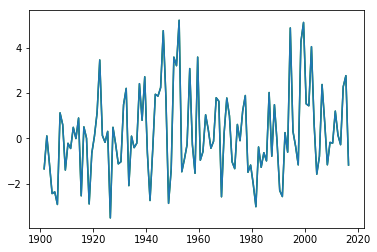

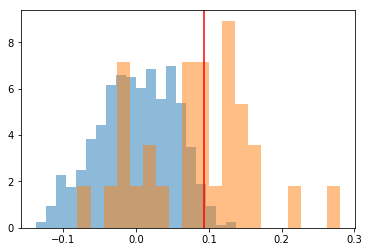

In [30]:
class OBS():
    def __init__(self,dataset,base_period=None):
        if base_period is None:
            base_period=('1900-1-1','1950-12-31')
        f=cdms.open("/Users/kmarvel/Google Drive/Sahel/DATA/CMIP5/INTENSITY/cmip5.sahel_precip_intensity."+dataset+".nc")
        self.raw={}
        self.bymonth={}
        self.anomalies={}
        self.climatology={}
        
        for variable in ["pr_CE","intensity_CE","pr_W","intensity_W"]:
            #raw data
            data=f(variable)
            if variable in ["pr_CE","pr_W"]:
                data=data/30.
            self.raw[variable]=data
            #partitioned by month
            bymonth=by_month(data)
            self.bymonth[variable]=bymonth
            #climatology
            clim=MV.average(bymonth(time=base_period),axis=0)
            self.climatology[variable]=clim
            #anomalies
            anomalies=cmip5.cdms_clone(bymonth.asma()-clim.asma(),bymonth)
            self.anomalies[variable]=anomalies
        f.close()
    def project_on_solver(self,solver,include=["pr_CE","intensity_CE","pr_W","intensity_W"],eof_number=0):
        #solver=self.fingerprint(include=include)
        fac=DA_tools.get_orientation(solver)
        nyears,nmonths=self.anomalies["pr_CE"].shape
        to_proj=[]
        
            
        for incl in include:
            dat=self.anomalies[incl]
            to_proj+=[dat/np.std(dat)]
        P=solver.projectField(to_proj)[:,eof_number]*fac
       
        return P
            
CRU=OBS("CRU")
Pcru_eof1=CRU.project_on_solver(h85.fingerprint(),eof_number=0)
Pcru_eof2=CRU.project_on_solver(h85.fingerprint(),eof_number=1)
Pcru_eof3=CRU.project_on_solver(h85.fingerprint(),eof_number=2)

Pcru_ghg=CRU.project_on_solver(cen21,eof_number=0)
Pcru_ghg_trunc=Pcru_ghg(time=('1900-1-1','2020-1-1'))
Pcru_aa=CRU.project_on_solver(aa.fingerprint(),eof_number=0)
Plotting.time_plot(Pcru_ghg,c="g")
Plotting.time_plot(Pcru_ghg_trunc)
len(Pcru_ghg)
noisecru=bootstrap_slopes(noiseh85,len(Pcru_ghg_trunc))
plt.figure()
plt.hist(noisecru,20,density=True,alpha=0.5)
plt.axvline(cmip5.get_linear_trends(Pcru_ghg),c="r")
modghg=h85.project_on_solver(time_bounds=('2000-1-1','2099-12-31'))\
    (time=(cmip5.start_time(Pcru_ghg_trunc),cmip5.stop_time(Pcru_ghg_trunc)))

plt.hist(cmip5.get_linear_trends(modghg),20,density=True,alpha=0.5)
#Plotting.time_plot(Pcru_aa,c="k")
#Plotting.time_plot(Pcru_eof3)



In [ ]:
time_bounds=('1950-1-1','1979-12-31')
Z=Pcru_aa(time=time_bounds)
PC=aa.fingerprint().pcs()[:,0](time=time_bounds)
Plotting.time_plot(PC)
Plotting.time_plot(Z)
print(PC.shape)
print(Z.shape)
signal=float(genutil.statistics.linearregression(Z,x=PC)[0])
P=aa.project_on_solver(projections_from=h85)(time=time_bounds)
plt.figure()
modsigs=[float(genutil.statistics.linearregression(Pi,x=PC)[0]) for Pi in P]
plt.hist(modsigs,density=True)
plt.axvline(signal)
test=bootstrap_slopes(noiseaa,len(Z.getTime()),x=PC)
plt.hist(test,density=True)

In [ ]:
#Plotting.time_plot()
Pcru_aa_trunc=Pcru_aa(time=('1950-1-1','1984-12-31'))
#Plotting.time_plot(Pcru_aa_trunc)
plt.figure()
noisecru_aa=bootstrap_slopes(noiseaa,len(Pcru_aa_trunc))
modaa=aa.project_on_solver()(time=('1950-1-1','1984-12-31'))


plt.hist(noisecru_aa,20,density=True)
plt.axvline(cmip5.get_linear_trends(Pcru_aa_trunc),c="r")

plt.hist(cmip5.get_linear_trends(modaa),20,density=True)

In [ ]:
def plot_obs(dataset):
    fobs=cdms.open("/Users/kmarvel/Google Drive/Sahel/DATA/OBS/PROCESSED/"+dataset+".nc")
    tot=fobs("pr_sahel")
    cdutil.setTimeBoundsMonthly(tot)
    data=cdutil.YEAR(tot,criteriaarg=(.5,None))
    Plotting.time_plot(data,label=dataset)
    east=fobs("pr_CE")
    cdutil.setTimeBoundsMonthly(east)
    dataeast=cdutil.YEAR(east)
    west=fobs("pr_W")
    cdutil.setTimeBoundsMonthly(west)
    datawest=cdutil.YEAR(west)
    dattot=dataeast+datawest
    Plotting.time_plot(0.5*dattot,ls=":",label=dataset)
    fobs.close()
#plot_obs("GPCP")
#plot_obs("PRECL")
#plot_obs("CMAP")

def plot_cru():
    dataset="CRU"
    f=cdms.open("/Users/kmarvel/Google Drive/Sahel/DATA/CMIP5/INTENSITY/cmip5.sahel_precip_intensity."+dataset+".nc")
    
    east=f("pr_CE")
    cdutil.setTimeBoundsMonthly(east)
    dataeast=cdutil.YEAR(east,criteriaarg=(.99,None))
    west=f("pr_W")
    cdutil.setTimeBoundsMonthly(west)
    datawest=cdutil.YEAR(west,criteriaarg=(.99,None))
    dattot=(dataeast+datawest)/30.
    Plotting.time_plot(0.5*dattot,ls="-",label=dataset)
    f.close()
#plot_cru()
plt.figure()

def plot_forcing(experiment):
    
    f=cdms.open("/Users/kmarvel/Google Drive/Sahel/DATA/CMIP5/cmip5.sahel_precip."+experiment+".nc")

    tot=MV.average(cmip5.ensemble2multimodel(f("pr_sahel")),axis=0)
    cdutil.setTimeBoundsMonthly(tot)
    data=cdutil.YEAR(tot,criteriaarg=(.99,None))
    Plotting.time_plot(data,label=dataset)
plot_forcing("AA")

In [ ]:
experiment="historical-rcp85"
f=cdms.open(cmip_directory+"cmip5.sahel_precip_intensity."+experiment+".nc")
X=f("intensity_CE")
print(X.getTime().asComponentTime()[6::12][0])
cmip5.start_time(by_month(X))

In [ ]:
def plot_monthly_polar(data,ax,**kwargs):
   # if ax is None:
      #  ax=plt.subplot(1,1,1,projection='polar')
    theta=np.linspace(0,2*np.pi,13)[:-1]
    if data.shape==(12,):
        ax.plot(theta,data,"o-",**kwargs)
    else:
        L=float(data.shape[0])
        i=0
        for datum in data:
            ax.plot(theta,datum,"o-",color=cm.RdYlBu(i/L))
            i+=1
    months=["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
    plt.thetagrids(np.rad2deg(theta),months)
    return ax